In [33]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from alphashape import alphashape


In [2]:
# import the example sentences with embeddings
data = pd.read_csv('example_sentences_embeddings.csv')

In [3]:
# create a new coumn "id", remove the string "essay" from the column "essay_id"
data['essay_id'] = data['essay_id'].str.replace('essay', '')  

In [4]:
# create a new column "treatment", essay 1- 51 are in the treatement group
data['treatment'] = np.where(data['essay_id'].astype(int) < 52, 1, 0)

In [5]:
# compute pairwise distance for each treatment group, use cosine distance
treatment_group = data[data['treatment'] == 1]
treatment_group = treatment_group.drop(columns=['essay_id', 'treatment', 'example sentences'])
# Convert each row to a numpy array
treatment_group ['embedding'] = treatment_group ['embedding'].apply(lambda x: np.array(eval(x)))
# calculate the pairwise distance using cosinse distance
treatment_group_similarity = cosine_similarity(treatment_group['embedding'].tolist(), treatment_group['embedding'].tolist())

# repeat the above steps for the control group
control_group = data[data['treatment'] == 0]
control_group = control_group.drop(columns=['essay_id', 'treatment', 'example sentences'])
control_group ['embedding'] = control_group ['embedding'].apply(lambda x: np.array(eval(x)))
control_group_similarity = cosine_similarity(control_group['embedding'].tolist(), control_group['embedding'].tolist())



In [34]:
# calculate average pairwise distance for each group
treatment_group_avg = np.mean(treatment_group_similarity)
control_group_avg = np.mean(control_group_similarity)
print(treatment_group_avg, control_group_avg)


# perform a t-test to determine if the difference in average pairwise distance is statistically significant
ttest = ttest_ind(treatment_group_similarity.flatten(), control_group_similarity.flatten())
print(ttest)

0.3527868832777525 0.37141681161589307
TtestResult(statistic=-30.374405947751242, pvalue=3.541454804418025e-202, df=195923.0)


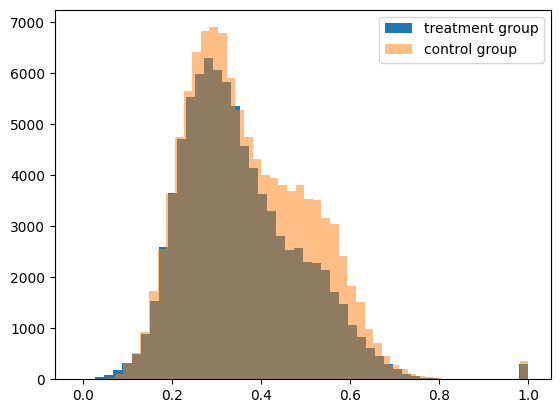

In [29]:
# plot histogram of pairwise distance for each group
plt.hist(treatment_group_similarity.flatten(), bins=50, alpha=1, label='treatment group')
plt.hist(control_group_similarity.flatten(), bins=50, alpha=0.5, label='control group')
plt.legend(loc='upper right')
plt.show()


{'whiskers': [<matplotlib.lines.Line2D at 0x11f317d40>,
 'caps': [<matplotlib.lines.Line2D at 0x11f52eba0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11f52e390>,
 'medians': [<matplotlib.lines.Line2D at 0x11f52f230>,
 'fliers': [<matplotlib.lines.Line2D at 0x11f52f590>,
 'means': []}

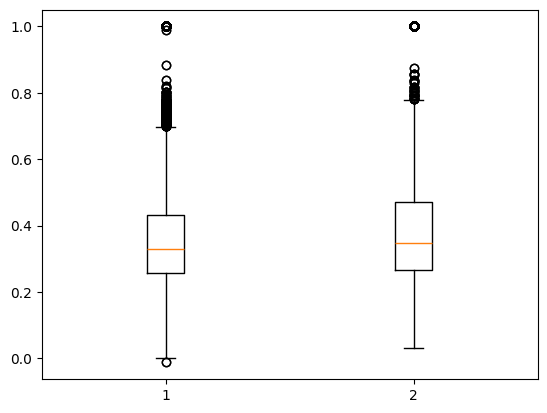

In [35]:
# use boxplot to display the distribution of pairwise distance for each group
plt.boxplot([treatment_group_similarity.flatten(), control_group_similarity.flatten()])

In [30]:
# calculate the standard deviation of the pairwise distance for each group
treatment_group_std = np.std(treatment_group_similarity)
control_group_std = np.std(control_group_similarity)
print(treatment_group_std, control_group_std)



0.13213174170800562 0.1370611477087171


### the next section is for grammar error analysis

In [38]:
# import the grammar_check_result.csv
grammar_check = pd.read_csv('grammar_check_result.csv')

# create a new coumn "essay_id", remove the string "essay" from the column "essay_id"
grammar_check['essay_id'] = grammar_check['essay_id'].str.replace('essay', '')  
# create a new column "treatment", essay 1- 51 are in the treatement group
grammar_check['treatment'] = np.where(grammar_check['essay_id'].astype(int) < 52, 1, 0)


In [42]:
grammar_check_avg = grammar_check.groupby(['treatment'])['quality_rating'].mean()
grammar_check_std = grammar_check.groupby(['treatment'])['quality_rating'].std()

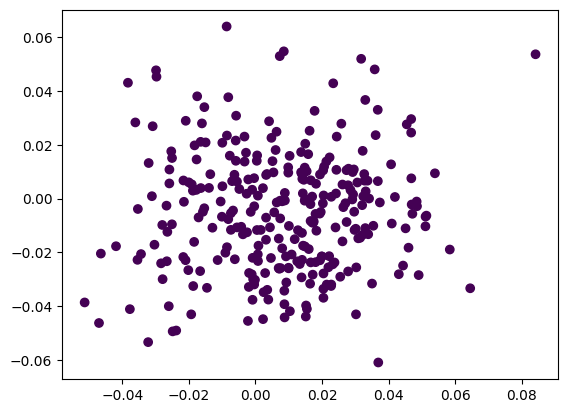

In [15]:
matrix_t = np.vstack(treatment_group['embedding'].values)
n_clusters = 1

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix_t)
treatment_group['Cluster'] = kmeans.labels_

# visualize the clusters
a = plt.scatter(matrix_t[:, 0], matrix_t[:, 1], c=kmeans.labels_, cmap='viridis')



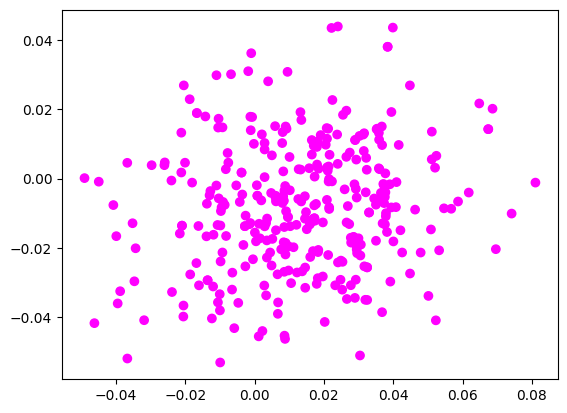

In [16]:
matrix_c = np.vstack(control_group['embedding'].values)
n_clusters = 1

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix_c)
control_group['Cluster'] = kmeans.labels_
# visualize the clusters
b = plt.scatter(matrix_c[:, 0], matrix_c[:, 1], c=kmeans.labels_, cmap='spring')

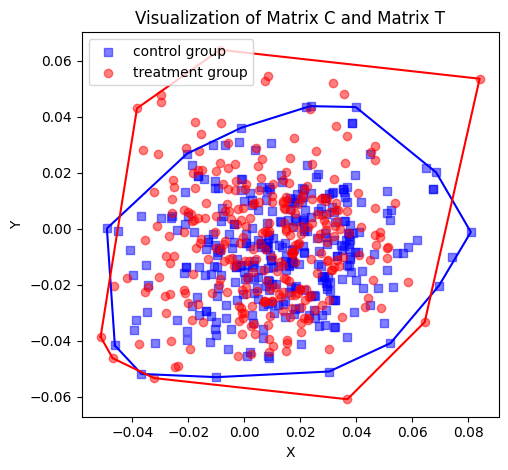

In [37]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot matrix_c as scatter points (using the first two dimensions)
c_scatter = ax.scatter(matrix_c[:, 0], matrix_c[:, 1], c='blue', label='control group', marker='s', alpha=0.5)

# Plot matrix_t as scatter points (using the first two dimensions)
t_scatter = ax.scatter(matrix_t[:, 0], matrix_t[:, 1], c='red', label='treatment group', marker='o', alpha=0.5)

# Compute the alpha shape for matrix_c
alpha_c = alphashape(matrix_c[:, :2], 0.1)  # Use the first two dimensions
if alpha_c.exterior is not None:
    ax.plot(*alpha_c.exterior.xy, color='blue')

# Compute the alpha shape for matrix_t
alpha_t = alphashape(matrix_t[:, :2], 0.1)  # Use the first two dimensions
if alpha_t.exterior is not None:
    ax.plot(*alpha_t.exterior.xy, color='red')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Example diversity')

# Set aspect ratio to equal
ax.set_aspect('equal')

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()